In [20]:
from database import get_database_prod
import pandas as pd
import yfinance as yf
from datetime import datetime
from functools import reduce
import numpy as np

import matplotlib.pyplot as plt

In [21]:
def get_market_year(row): #make a market year row in datas
    year = row['Date'].year
    month = row['Date'].month
    if month >= 6: #month starting market year
        market_year = f"{year}/{str(year + 1)[-2:]}"
    else:
        market_year = f"{year - 1}/{str(year)[-2:]}"
    return market_year

In [22]:
def real_year_projestflag(row):
    if row["ProjEstFlag"] == "Curr.":
        date = row["Date"] - pd.DateOffset(years=2)
    elif row["ProjEstFlag"] == "Est.":
        date = row["Date"] - pd.DateOffset(years=1)
    else:
        date = row["Date"]
    return date

In [23]:
def get_continuous_wheat_prices():
    zw = pd.read_csv("files/ZWFutures.csv")
    zw = zw.rename(columns={"Date Time": "Date"})
    zw["Date"] = pd.to_datetime(zw["Date"])
    zw["MarketYear"] = zw.apply(get_market_year, axis=1)
    #continuous is simple : current contract is the one in front, roll is done when current contract expires
    zw_continuous = zw.groupby("Date").first().reset_index()
    zw_continuous["Year-Month"] = zw_continuous["Date"].dt.to_period("M")
    return zw_continuous

In [24]:
zw_continuous = get_continuous_wheat_prices()

y : CBOT Wheat price (monthly avergae)

In [25]:
zw_monthly_average = zw_continuous[zw_continuous["Year-Month"] != "2025-04"].resample("ME", on="Date").agg({
    "Date": "first",
    "Close": "mean",
    "MarketYear": "first",
    "Year-Month": "first"
})
zw_monthly_average = zw_monthly_average.rename(columns={"Close": "Wheat"}).reset_index(drop=True)
zw_monthly_average.tail()

,Date,Wheat,MarketYear,Year-Month
550,2024-11-01,551.987500,2024/25,2024-11
551,2024-12-02,540.869048,2024/25,2024-12
552,2025-01-02,545.404762,2024/25,2025-01
553,2025-02-03,577.302632,2024/25,2025-02
554,2025-03-03,543.166667,2024/25,2025-03


US and World Stock Use Ratio Yearly

In [26]:
#get usda data from db
usda_collection = get_database_prod()["agri_data"]["wasde"]
usda_europe = usda_collection.find({
    "Region" : {"$in": ["World", "United States"]}
})
usda_df = pd.DataFrame(list(usda_europe))

#get old data from txt
old_usda_report = pd.read_csv("files/old_yearly_usda_wheat_report.txt") 

#perform transformation for manipulation
usda_df = usda_df.rename(columns={"ReleaseDate": "Date"})
usda_df["Date"] = pd.to_datetime(usda_df["Date"])
usda_df["ReleaseDateMY"] = usda_df.apply(get_market_year, axis=1)
usda_df = usda_df[usda_df["Commodity"] == "Wheat"]

#same for stock to use needed values
usda_wheat_stckuse = usda_df[(usda_df["Attribute"].isin(["Domestic Total", "Exports", "Ending Stocks"])) & (usda_df["ReportTitle"] == "World Wheat Supply and Use")][["Date", "Region", "MarketYear", "Attribute", "Value", "ProjEstFlag"]].reset_index(drop=True)

#fill na values of proj est flag to current : pivot remove NaN values
usda_wheat_stckuse["ProjEstFlag"] = usda_wheat_stckuse["ProjEstFlag"].fillna("Curr.")

#pivot data and filter on region
usda_wheat_stckuse = usda_wheat_stckuse.pivot_table(index=['Date', 'Region', 'MarketYear', 'ProjEstFlag'], 
                           columns='Attribute', 
                           values='Value').reset_index()
us_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "United States"]
world_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "World"]

old_usda_report = old_usda_report.pivot_table(index=['Region', 'MarketYear', "Year"], 
                           columns='Attribute', 
                           values='Value').reset_index()
old_us_wheat_stckuse = old_usda_report[old_usda_report["Region"] == "United States"]
old_world_wheat_stckuse = old_usda_report[old_usda_report["Region"] == "World"]

#groupby market year to get only the last market year numbers 
us_last_wheat_stckuse = us_wheat_stckuse.groupby("MarketYear").last().reset_index()
us_last_wheat_stckuse["Date"] = us_last_wheat_stckuse.apply(real_year_projestflag, axis=1)

world_last_wheat_stckuse = world_wheat_stckuse.groupby("MarketYear").last().reset_index()
world_last_wheat_stckuse["Date"] = world_last_wheat_stckuse.apply(real_year_projestflag, axis=1)

#concat old and new dataset
us_last_wheat_stckuse = pd.concat([old_us_wheat_stckuse, us_last_wheat_stckuse])
world_last_wheat_stckuse = pd.concat([old_world_wheat_stckuse, world_last_wheat_stckuse])

#add date field when NaN
us_last_wheat_stckuse.loc[us_last_wheat_stckuse["Date"].isna(), "Date"] = pd.to_datetime(us_last_wheat_stckuse.loc[us_last_wheat_stckuse["Date"].isna(), "Year"].astype(str).str[:-2] + "-04-10", format="%Y-%m-%d")
us_last_wheat_stckuse = us_last_wheat_stckuse.reset_index(drop=True)

world_last_wheat_stckuse.loc[world_last_wheat_stckuse["Date"].isna(), "Date"] = pd.to_datetime(world_last_wheat_stckuse.loc[world_last_wheat_stckuse["Date"].isna(), "Year"].astype(str).str[:-2] + "-04-10", format="%Y-%m-%d")
world_last_wheat_stckuse = world_last_wheat_stckuse.reset_index(drop=True)

#perform stock to use calc
us_last_wheat_stckuse["StckUse"] = (us_last_wheat_stckuse["Ending Stocks"] / (us_last_wheat_stckuse["Domestic Total"] + us_last_wheat_stckuse["Exports"])) * 100
world_last_wheat_stckuse["StckUse"] = (world_last_wheat_stckuse["Ending Stocks"] / (world_last_wheat_stckuse["Domestic Total"] + world_last_wheat_stckuse["Exports"])) * 100

#merge dfs, rename field and keep wanted data
stck_to_use = pd.merge(us_last_wheat_stckuse, world_last_wheat_stckuse, on=["MarketYear", "Date"], how="inner")
stck_to_use = stck_to_use.rename(columns={
    "StckUse_x": "StckUse_US",
    "StckUse_y": "StckUse_World",
})
stck_to_use["Year-Month"] = stck_to_use["Date"].dt.to_period("M")
stck_to_use = stck_to_use[["StckUse_US", "StckUse_World", "Year-Month"]]

stck_to_use_monthly = pd.DataFrame(index=pd.Index(pd.date_range(start='4/1/1981', end=datetime.today().strftime("%m/%d/%Y"), freq='ME'), name="Date")).reset_index()
stck_to_use_monthly["Year-Month"] = stck_to_use_monthly["Date"].dt.to_period("M")

stck_to_use_monthly = pd.merge(stck_to_use_monthly, stck_to_use, on="Year-Month", how="outer")
stck_to_use_monthly = stck_to_use_monthly.bfill()
stck_to_use_monthly = stck_to_use_monthly[["StckUse_US", "StckUse_World", "Year-Month"]]
stck_to_use_monthly.head()

,StckUse_US,StckUse_World,Year-Month
0,43.178170,13.799448,1981-04
1,44.335664,15.404040,1981-05
2,44.335664,15.404040,1981-06
3,44.335664,15.404040,1981-07
4,44.335664,15.404040,1981-08


US and World Stock Use Ratio Monthly

In [26]:
#get usda data from db
usda_collection = get_database_prod()["agri_data"]["wasde"]
usda_europe = usda_collection.find({
    "Region" : {"$in": ["World", "United States"]}
}).sort("ReleaseDate", -1)
usda_df = pd.DataFrame(list(usda_europe))

#perform transformation for manipulation
usda_df = usda_df.rename(columns={"ReleaseDate": "Date"})
usda_df["Date"] = pd.to_datetime(usda_df["Date"])
usda_df["ReleaseDateMY"] = usda_df.apply(get_market_year, axis=1)
usda_df = usda_df[usda_df["Commodity"] == "Wheat"]

#same for stock to use needed values
usda_wheat_stckuse = usda_df[(usda_df["Attribute"].isin(["Domestic Total", "Exports", "Ending Stocks"])) & (usda_df["ReportTitle"] == "World Wheat Supply and Use")][["Date", "Region", "MarketYear", "Attribute", "Value", "ProjEstFlag"]].reset_index(drop=True)

#fill na values of proj est flag to current : pivot remove NaN values
usda_wheat_stckuse["ProjEstFlag"] = usda_wheat_stckuse["ProjEstFlag"].fillna("Curr.")

#pivot data and filter on region
usda_wheat_stckuse = usda_wheat_stckuse.pivot_table(index=['Date', 'Region', 'MarketYear', 'ProjEstFlag'], 
                           columns='Attribute', 
                           values='Value').reset_index()
us_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "United States"]
world_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "World"]

us_wheat_stckuse = us_wheat_stckuse.groupby("Date").last().reset_index()
world_wheat_stckuse = world_wheat_stckuse.groupby("Date").last().reset_index()

us_wheat_stckuse["StckUse"] = (us_wheat_stckuse["Ending Stocks"] / (us_wheat_stckuse["Domestic Total"] + us_wheat_stckuse["Exports"])) * 100
world_wheat_stckuse["StckUse"] = (world_wheat_stckuse["Ending Stocks"] / (world_wheat_stckuse["Domestic Total"] + world_wheat_stckuse["Exports"])) * 100

stck_to_use = pd.merge(us_wheat_stckuse, world_wheat_stckuse, on=["MarketYear", "Date"], how="inner")
stck_to_use = stck_to_use.rename(columns={
    "StckUse_x": "StckUse_US",
    "StckUse_y": "StckUse_World",
})
stck_to_use["Year-Month"] = stck_to_use["Date"].dt.to_period("M")
stck_to_use = stck_to_use[["StckUse_US", "StckUse_World", "Year-Month"]]
stck_to_use.head()

Attribute,StckUse_US,StckUse_World,Year-Month
0,19.004111,16.970729,1995-06
1,18.077519,16.148103,1995-07
2,18.487266,15.880223,1995-08
3,18.031008,15.165906,1995-09
4,16.492789,14.822258,1995-10


WTI Crude oil prices (monthly average)

In [27]:
cl = pd.read_csv("files/CL-1983-Today.csv")[:-1]
cl["Date"] = pd.to_datetime(cl["Date"])
cl["Year-Month"] = cl["Date"].dt.to_period("M")
cl_monthly_mean = cl.resample("ME", on="Date").agg({
    "Date": "first",
    "Close": "mean",
    "Year-Month": "first"
})
cl_monthly_mean = cl_monthly_mean[1:-1]
cl_monthly_mean = cl_monthly_mean.rename(columns={"Close": "WTI"}).reset_index(drop=True)[["WTI", "Year-Month"]]
cl_monthly_mean.head()

,WTI,Year-Month
0,30.500500,1983-04
1,30.143810,1983-05
2,30.929545,1983-06
3,31.567500,1983-07
4,31.882174,1983-08


Urea prices (monthly average)

In [28]:
fert = pd.read_excel("files/world-bank-monthly-prices.xlsx", skiprows=4, sheet_name="Monthly Prices")
fert = fert[1:]
fert = fert.rename(columns={"Unnamed: 0": "Date", "Urea ": "Urea"})
fert["Date"] = pd.to_datetime(fert["Date"], format="%YM%m")
fert["Year-Month"] = fert["Date"].dt.to_period("M")
urea = fert[["Urea", "Year-Month"]]

fert["DAP"] = fert["DAP"].replace("...", np.nan)
fert["Fert."] = fert[["TSP", "Urea", "DAP"]].mean(axis=1)
fert = fert[["Fert.", "Year-Month"]]

fert.tail()

C:\Users\alexl\AppData\Local\Temp\ipykernel_15364\4265471918.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fert["DAP"] = fert["DAP"].replace("...", np.nan)


,Fert.,Year-Month
779,472.6,2024-11
780,465.943333,2024-12
781,480.4,2025-01
782,506.96,2025-02
783,496.043333,2025-03


Dollar index (monthly average)

In [29]:
dollar = yf.download("DX-Y.NYB", start="1970-01-01", period="1mo").droplevel(1, axis=1)
monthly_dollar_mean = dollar.resample("ME").agg({
    'Close': 'mean',
}).reset_index()
monthly_dollar_mean["Year-Month"] = monthly_dollar_mean["Date"].dt.to_period("M")
monthly_dollar_mean = monthly_dollar_mean[:-1]
monthly_dollar_mean = monthly_dollar_mean.rename(columns={"Close": "Dollar"})[["Dollar", "Year-Month"]]

monthly_dollar_mean.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Dollar,Year-Month
647,107.190000,2024-12
648,108.609047,2025-01
649,107.353157,2025-02
650,104.187143,2025-03
651,100.717619,2025-04


Managed money net positions (monthly average) and his categorical variable

In [30]:
cot_wheat_col = get_database_prod()["cot_data"]["us_commodity"]
cot_wheat_cursor = cot_wheat_col.find({
    "Market_and_Exchange_Names" : "WHEAT-SRW - CHICAGO BOARD OF TRADE"
    }).sort("Date", 1)
cot_wheat = pd.DataFrame(list(cot_wheat_cursor))[["Date", "M_Money_Positions_Long_All", "M_Money_Positions_Short_All"]]
cot_wheat = cot_wheat[cot_wheat["Date"] >= "2006-06-01"]
cot_wheat["MM_Net"] = cot_wheat["M_Money_Positions_Long_All"] - cot_wheat["M_Money_Positions_Short_All"]
cot_wheat_monthly_average = cot_wheat.resample("ME", on="Date").agg({
    "MM_Net": "mean"
}).reset_index()
cot_wheat_monthly_average["Year-Month"] = cot_wheat_monthly_average["Date"].dt.to_period("M")
cot_wheat_monthly_average["MM_Categorical"] = 1

cot_categ = pd.DataFrame(index=pd.Index(pd.date_range(start='1/1/1970', end="6/1/2006", freq='ME'), name="Date"))
cot_categ["MM_Categorical"] = 0
cot_categ["MM_Net"] = 0
cot_categ = cot_categ.reset_index()
cot_categ["Year-Month"] = cot_categ["Date"].dt.to_period("M")

cot_wheat_monthly_average_categorical = pd.concat([cot_categ, cot_wheat_monthly_average])
cot_wheat_monthly_average_categorical = cot_wheat_monthly_average_categorical[["MM_Net", "MM_Categorical", "Year-Month"]]
cot_wheat_monthly_average_categorical.head()

,MM_Net,MM_Categorical,Year-Month
0,0.0,0,1970-01
1,0.0,0,1970-02
2,0.0,0,1970-03
3,0.0,0,1970-04
4,0.0,0,1970-05


Seasonality weighting

In [31]:
zw_monthly_average_season = zw_monthly_average[~zw_monthly_average["MarketYear"].isin(["1978/79", "2024/25"])]

zw_monthly_average = zw_monthly_average[["Wheat", "Year-Month"]] #Now we keep only wanted columns for zw monthly average

zw_monthly_average_season["Month"] = zw_monthly_average_season["Date"].dt.month
zw_monthly_average_season = zw_monthly_average_season[["Month", "Wheat"]].groupby("Month").mean()

zw_overall_avg = zw_continuous['Close'].mean()

zw_seasonality_weight = zw_monthly_average_season / zw_overall_avg
zw_seasonality_weight = zw_seasonality_weight.rename(columns={"Wheat": "Seasonality_Weight"})
zw_seasonality_weight = zw_seasonality_weight.reset_index()

seasonality_weights = pd.DataFrame(index=pd.Index(pd.date_range(start='1/1/1985', end=datetime.today().strftime("%d/%m/%Y"), freq='ME'), name="Date")).reset_index()
seasonality_weights["Year-Month"] = seasonality_weights["Date"].dt.to_period("M")
seasonality_weights["Month"] = seasonality_weights["Date"].dt.month

seasonality_weights = pd.merge(seasonality_weights, zw_seasonality_weight, on="Month", how="inner")
seasonality_weights = seasonality_weights[["Seasonality_Weight", "Year-Month"]]
seasonality_weights.tail()

,Seasonality_Weight,Year-Month
479,1.006274,2024-12
480,1.012663,2025-01
481,1.008943,2025-02
482,1.010058,2025-03
483,0.996753,2025-04


Business Cycle

In [32]:
#Paper time interval : 1998 to 2006 and 2007 to 2019. We add 2020 to today
interval_map = {
    0: ["1998-01-01", "2006-12-31"],
    1: ["2007-01-01", "2019-12-31"],
    2: ["2020-01-01", datetime.today().strftime("%Y-%m-%d")]
}
business_rank = dict()
cycle_weights = dict()

for k, v in interval_map.items():
    cycle_mean = zw_continuous[(zw_continuous["Date"] >= v[0]) & (zw_continuous["Date"] <= v[1])]["Close"].mean()
    business_rank[cycle_mean] = v

max_key = max(business_rank, key=business_rank.get)

for key, value in business_rank.items():
    weight = key / max_key
    cycle_weights[weight] = value

business_cycle_weights = pd.DataFrame(index=pd.Index(pd.date_range(start='1/1/1998', end=datetime.today().strftime("%m/%d/%Y"), freq='ME'), name="Date")).reset_index()
business_cycle_weights["Year-Month"] = business_cycle_weights["Date"].dt.to_period("M")

for kk, vv in cycle_weights.items():
    business_cycle_weights.loc[(business_cycle_weights["Date"] >= vv[0]) & 
                           (business_cycle_weights["Date"] <= vv[1]), 
                           "Business_Cycle_Weight"] = kk

business_cycle_weights = business_cycle_weights[["Business_Cycle_Weight", "Year-Month"]]
business_cycle_weights.tail()

,Business_Cycle_Weight,Year-Month
323,1.0,2024-12
324,1.0,2025-01
325,1.0,2025-02
326,1.0,2025-03
327,1.0,2025-04


Political risks and uncertainties

In [33]:
#Event in the paper : Black Monday in oct 1987, US Savings and Loan Crisis between jan 1989 and  dec 1991, Dot-com Bubble between march 2000 and end 2001, Global Financial Crisis between oct 2007 and end 2008
#trade war between the USA and China between jan 2018 and feb 2020
#Event I will add : COVID 19 -> feb 2020 to june of 2021 ; Russian invasion -> feb 2022 deb 2023 ; Trump president and tariffs -> feb 2025 now

uncertainty_map = {
    0: ["1987-10-01", "1987-10-31"],
    1: ["1989-01-01", "1991-12-31"],
    2: ["2000-03-01", "2021-12-31"],
    3: ["2007-10-01", "2008-12-31"],
    4: ["2018-01-01", "2020-02-29"],
    5: ["2020-02-01", "2021-06-30"],
    6: ["2022-02-01", "2023-01-31"],
    7: ["2025-02-01", datetime.today().strftime("%Y-%m-%d")]
}

uncertainty_categ = pd.DataFrame(index=pd.Index(pd.date_range(start='1/1/1985', end=datetime.today().strftime("%m/%d/%Y"), freq='ME'), name="Date")).reset_index()
uncertainty_categ["Year-Month"] = uncertainty_categ["Date"].dt.to_period("M")
uncertainty_categ["Uncertain"] = 0

for _, v in uncertainty_map.items():
    uncertainty_categ.loc[(uncertainty_categ["Date"] >= v[0]) & 
                           (uncertainty_categ["Date"] <= v[1]), 
                           "Uncertain"] = 1
uncertainty_categ = uncertainty_categ[["Uncertain", "Year-Month"]]
uncertainty_categ.tail()

,Uncertain,Year-Month
479,0,2024-12
480,0,2025-01
481,1,2025-02
482,1,2025-03
483,1,2025-04


Concatenate dataset

In [34]:
datas_df = [zw_monthly_average, stck_to_use, urea, cl_monthly_mean, monthly_dollar_mean, cot_wheat_monthly_average_categorical, seasonality_weights, uncertainty_categ, business_cycle_weights]
df = reduce(lambda  left, right: pd.merge(left, right, on="Year-Month", how='inner'), datas_df)

In [35]:
df

,Wheat,Year-Month,StckUse_US,StckUse_World,Urea,WTI,Dollar,MM_Net,MM_Categorical,Seasonality_Weight,Uncertain,Business_Cycle_Weight
0,331.875000,1998-01,28.518519,19.301368,86.25,16.757000,100.411818,0.000000,0,1.012663,0,0.467092
1,330.381579,1998-02,28.256852,19.038445,77.5,16.115263,99.815500,0.000000,0,1.008943,0,0.467092
2,328.272727,1998-03,28.256852,18.706431,84.5,15.112273,100.363636,0.000000,0,1.010058,0,0.467092
3,301.226190,1998-04,31.082782,19.249450,100,15.564286,100.169090,0.000000,0,0.996753,0,0.467092
4,295.212500,1998-05,31.344853,18.762575,95,15.204000,99.479048,0.000000,0,1.005457,0,0.467092
...,...,...,...,...,...,...,...,...,...,...,...,...
320,551.987500,2024-11,41.292606,25.299584,352.3,69.501500,105.843500,-42544.666667,1,1.000788,0,1.000000
321,540.869048,2024-12,39.782969,25.378892,352,69.565714,107.190000,-79120.500000,1,1.006274,0,1.000000
322,545.404762,2025-01,39.886092,25.527424,380.5,74.740476,108.609047,-96401.000000,1,1.012663,0,1.000000
323,577.302632,2025-02,39.655172,25.432750,436.5,71.178947,107.353157,-75610.500000,1,1.008943,1,1.000000


In [36]:
df.isna().sum()

Wheat                    0
Year-Month               0
StckUse_US               0
StckUse_World            0
Urea                     0
WTI                      0
Dollar                   0
MM_Net                   0
MM_Categorical           0
Seasonality_Weight       0
Uncertain                0
Business_Cycle_Weight    0
dtype: int64

In [37]:
df = df.dropna() #drop nan after seeing that only nan values are the last stck use ratio

In [38]:
df.to_csv("dataset/model_dataset1998.csv")

In [39]:
df_corr = df.drop("Year-Month", axis=1)

In [40]:
df_corr.corr()  # matrice de corrélation

,Wheat,StckUse_US,StckUse_World,Urea,WTI,Dollar,MM_Net,MM_Categorical,Seasonality_Weight,Uncertain,Business_Cycle_Weight
Wheat,1.000000,-0.152700,0.291541,0.821554,0.818576,-0.448715,0.110040,0.739749,0.014179,0.169747,0.762210
StckUse_US,-0.152700,1.000000,0.656436,-0.100799,-0.165762,0.271373,-0.454606,0.279552,0.019946,-0.105779,0.337661
StckUse_World,0.291541,0.656436,1.000000,0.294051,0.163776,0.107877,-0.387969,0.564199,0.010432,0.097593,0.665449
Urea,0.821554,-0.100799,0.294051,1.000000,0.774681,-0.316137,-0.037012,0.612050,-0.002437,0.144151,0.658964
WTI,0.818576,-0.165762,0.163776,0.774681,1.000000,-0.597369,-0.037128,0.688415,-0.060875,0.215233,0.644274
Dollar,-0.448715,0.271373,0.107877,-0.316137,-0.597369,1.000000,-0.252136,-0.408710,0.009682,-0.326653,-0.265758
MM_Net,0.110040,-0.454606,-0.387969,-0.037012,-0.037128,-0.252136,1.000000,-0.251182,-0.114351,0.209475,-0.301914
MM_Categorical,0.739749,0.279552,0.564199,0.612050,0.688415,-0.408710,-0.251182,1.000000,-0.021226,0.185540,0.931982
Seasonality_Weight,0.014179,0.019946,0.010432,-0.002437,-0.060875,0.009682,-0.114351,-0.021226,1.000000,-0.025011,0.005605
Uncertain,0.169747,-0.105779,0.097593,0.144151,0.215233,-0.326653,0.209475,0.185540,-0.025011,1.000000,0.076998


In [10]:
us_wheat_stckuse

Attribute,Date,Region,MarketYear,ProjEstFlag,Domestic Total,Ending Stocks,Exports,StckUse
0,1995-06-12,United States,1995/96,Curr.,33.01,12.48,32.66,19.004111
1,1995-07-12,United States,1995/96,Curr.,33.20,11.66,31.30,18.077519
2,1995-08-14,United States,1995/96,Curr.,33.20,12.05,31.98,18.487266
3,1995-09-12,United States,1995/96,Curr.,32.52,11.63,31.98,18.031008
4,1995-10-11,United States,1995/96,Curr.,32.52,10.75,32.66,16.492789
...,...,...,...,...,...,...,...,...
353,2025-01-10,United States,2024/25,Proj.,31.30,21.71,23.13,39.886092
354,2025-02-11,United States,2024/25,Proj.,31.39,21.62,23.13,39.655172
355,2025-03-11,United States,2024/25,Proj.,31.39,22.30,22.73,41.204730
356,2025-04-10,United States,2024/25,Proj.,31.34,23.03,22.32,42.918375


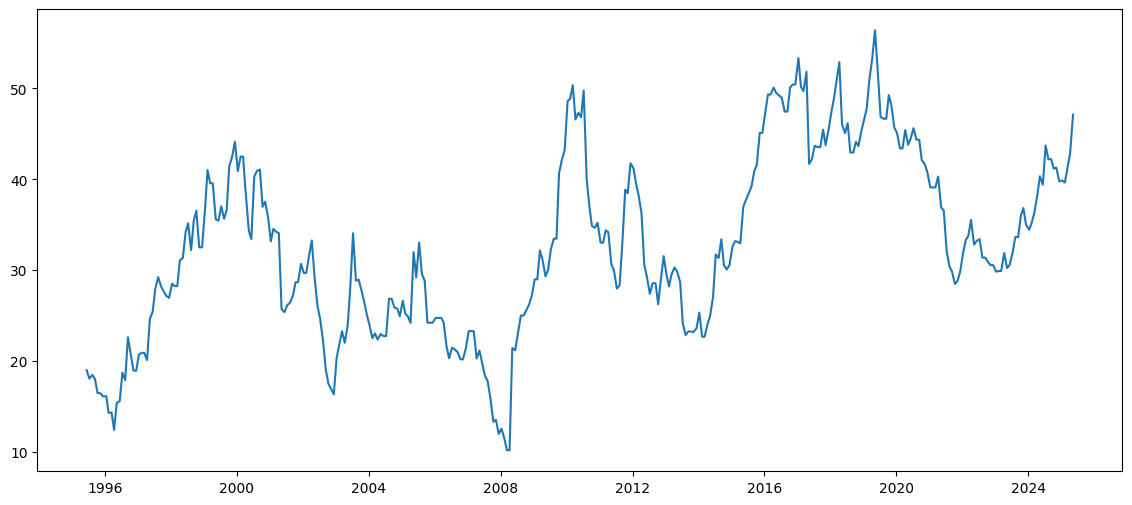

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(us_wheat_stckuse["Date"], us_wheat_stckuse["StckUse"])
plt.show()